# Survival Analysis of 4dm4 Data

## Description

This notebook is for the Survival Analysis of 4dm4 Data based on Qualifiers Scores of Each team

## Initialization

### Import the modules

Before Importing the modules, we need to change the main directory first in order to obtain `utils` (or utility) module

In [1]:
import os

os.chdir("..")

Then we import `matplotlib` and `pandas` for Data Visualization and Manipulation. `lifelines` for Survival Analysis models. `utils.Dataset` and `utils.get_table` for dealing with our SQLite3 `.db`

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import Dataset
from lifelines import KaplanMeierFitter, CoxPHFitter
from utils import get_table

### Defining Table Names

In this study, we will use `team_data` and `team_scores` table

In [3]:
TEAM_DATA = 'team_data'
TEAM_SCORES = 'team_scores'

## Importing Dataset

We use the downloaded data `4dm4.db` for this study, which is the spreadsheet data transformed into `sqlite Database` 

In [4]:
_4dm3_teams = Dataset('datasets/4dm3.db')

### Querying the Data

for Qualifiers Scores, we query the qualifiers score where the following teams are qualified from Qualification Procedure

for Survival Round, we query the last_rdint where the following teams are qualified from Qualification Procedure

In [5]:
# Qualifiers Score
_4dm3_teams_qualifier_score = _4dm3_teams.query("""
select team_scores.country_name, team_scores.round, team_scores.beatmap_type, team_scores.beatmap_tag, team_scores.score_logit 
from team_scores left join team_data on team_scores.country_name = team_data.country_name 
where round="Q" and team_data.last_round != "Q"
""")
# Survive
_4dm3_teams_round_survive = _4dm3_teams.select(TEAM_DATA, ['country_name', 'last_rdint'], {'last_round': "!= \"Q\""})

In [6]:
_4dm3_teams_qualifier_score.head()

,country_name,round,beatmap_type,beatmap_tag,score_logit
0,Argentina,Q,HB,1,3.576483
1,Argentina,Q,LN,1,3.000425
2,Argentina,Q,RC,1,4.819148
3,Argentina,Q,RC,2,3.537350
4,Argentina,Q,SV,1,3.619150


In [7]:
_4dm3_teams_round_survive.head()

,country_name,last_rdint
0,Argentina,1
1,Australia,1
2,Belgium,3
3,Brazil,6
4,Canada,1


### Defining Functions to Translate Data

- `die` ~~idk what am i thinking when trying to name a function~~ is a function to tell whether the team is Eliminated. All teams are Eliminated (1) except `Philippines` (4dm3 Champion) so we will mark them as `Censored` which is 0

In [8]:
def die(country):
    if country == "Philippines":
        return 0
    return 1

### Translate Data

In this procedure, we transform the Qualifiers Scores into a table which has the `time` and `status` and other parameters by the module and translate the Survival Data using the function defined above.

In [9]:
# translate qualifiers data into tables

_4dm3_teams_qualifiers_table = get_table(_4dm3_teams_qualifier_score)

# Translate the survival data

_4dm3_teams_round_survive.index = _4dm3_teams_round_survive['country_name']
_4dm3_teams_round_survive['time'] = _4dm3_teams_round_survive['last_rdint']
_4dm3_teams_round_survive['status'] = _4dm3_teams_round_survive['country_name'].apply(die)

In [10]:
_4dm3_teams_qualifiers_table.head()

,Q_HB_1,Q_LN_1,Q_RC_1,Q_RC_2,Q_SV_1
Argentina,3.576483,3.000425,4.819148,3.537350,3.619150
Australia,3.670724,3.116724,5.046926,3.936525,3.539281
Belgium,3.731808,3.405876,5.198285,3.866169,4.266866
Brazil,4.713861,4.415284,6.126861,4.618139,4.791950
Canada,3.384376,2.859818,5.060566,3.086721,3.118974


In [11]:
_4dm3_teams_round_survive.head()

,country_name,last_rdint,time,status
country_name,,,,
Argentina,Argentina,1,1,1
Australia,Australia,1,1,1
Belgium,Belgium,3,3,1
Brazil,Brazil,6,6,1
Canada,Canada,1,1,1


## Exploratory Data Analysis

### Survival Histogram

We start by plotting the Survival Distribution of teams

In [12]:
T = _4dm3_teams_round_survive['time']
E = _4dm3_teams_round_survive['status']

(array([16.,  0.,  1.,  0.,  3.,  0.,  6.,  0.,  3.,  3.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

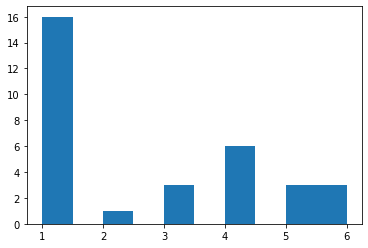

In [13]:
plt.hist(T)

### Kaplan-Meier Model

This model tells the Discrete `Survival Probability` over `time` with some confidence interval as shown in this code.

<AxesSubplot:xlabel='timeline'>

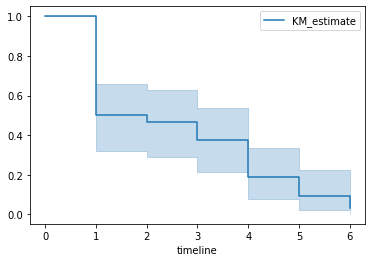

In [14]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

Here, we use the model to plot the cumulative density. In other words, cumulative relative frequency of teams who are ~~dead~~ eliminated

<AxesSubplot:xlabel='timeline'>

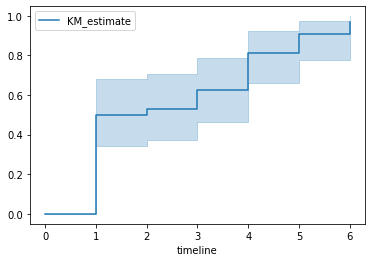

In [15]:
kmf.plot_cumulative_density()

### Calculating Median Survival Times using Kaplan-Meier Model

Median Survival Times is the middle value of the survival times, we calculate the median and confidence interval of them.

In [16]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

median_

1.0

In [17]:
median_confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,1.0,4.0


## Data Preprocessing

In this process, we only concatenate `Qualifiers Score` and `Survival Time` and `Status` together.

In [18]:
data = _4dm3_teams_qualifiers_table

data['time'] = _4dm3_teams_round_survive['time']
data['status'] = _4dm3_teams_round_survive['status']

data.head()

,Q_HB_1,Q_LN_1,Q_RC_1,Q_RC_2,Q_SV_1,time,status
Argentina,3.576483,3.000425,4.819148,3.537350,3.619150,1,1
Australia,3.670724,3.116724,5.046926,3.936525,3.539281,1,1
Belgium,3.731808,3.405876,5.198285,3.866169,4.266866,3,1
Brazil,4.713861,4.415284,6.126861,4.618139,4.791950,6,1
Canada,3.384376,2.859818,5.060566,3.086721,3.118974,1,1


## Survival Analysis Models



### Cox-Proportional Hazard Model

Cox-Proportional Hazard Model is used to find the odds ratio of the parameters, namely "How the variable changes affect the survival chance". This model is implemented by using non-parametric method with the exponential model and some complicated stuff under the assumption that the odds ratio is a constant. We use this model to observe how the changes in qualifiers scores of each stage affect the chance of being qualified. 

#### Model Fitting and Summary

In [19]:
coxph = CoxPHFitter()

In [20]:
coxph.fit(data, duration_col='time', event_col='status')

<lifelines.CoxPHFitter: fitted with 32 total observations, 1 right-censored observations>

In [21]:
coxph.print_summary(decimals=3)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 32 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 32
number of events observed = 31
   partial log-likelihood = -67.858
         time fit was run = 2022-08-02 06:20:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Q_HB_1    -0.072      0.930      1.213           -2.450            2.306                0.086               10.033
Q_LN_1    -0.969      0.379      0.677           -2.297            0.359                0.101                1.431
Q_RC_1     0.969      2.635      1.011           -1.012            2.949                0.364               19.095
Q_RC_2     0.175      1.191      0.734           -1.264            1.613                0.283                5.017
Q_SV_1    -2.095      0.123      0.879           -3.818           -0.371                0.022                0.690

            cmp to      z     p   -log2(p)
covariate                                 
Q_HB_1       0.000 -0.059 0.953      0.070
Q_LN_1       0.000 -1.431 0.153      2.713
Q_RC_1       0.000  0.959 0.338      1.566
Q_RC_2       0.000  0.238 0.812      0.301
Q_SV_1       0.000 -2.382 0.017      5.860
---
Concordance = 0.918
Partial AIC = 145.715
log-likelihood ratio test = 27.401 on 5 df
-log2(p) of ll-ratio test = 14.357

From the summary of the **Cox-Proportional Hazard Model** we can see that 

- **Q_SV_1** or [**Blackorient**](https://osu.ppy.sh/beatmapsets/1349422#mania/2793977) affects the chance of survival by reducing the odds of elimination by approximately **12%** if the **score_logit** is increased by 1.
- **Q_RC_1** or [**My Cloud**](https://osu.ppy.sh/beatmapsets/1349413#mania/2793965) affects the chance of survival by increasing the odds of elimination by approximately **163%** if the **score_logit** is increased by 1.
- **Q_LN_1** or [**Axeria**](https://osu.ppy.sh/beatmapsets/1349415#mania/2793968) affects the chance of survival by reducing the odds of elimination by approximately **62%** if the **score_logit** is increased by 1.
- **Q_RC_2** or [**Old Nothing**](https://osu.ppy.sh/beatmapsets/1349409#mania/2793960) affects the chance of survival by increasing the odds of elimination by approximately **20%** if the **score_logit** is increased by 1.
- **Q_HB_1** or [**Mei Mode**](https://osu.ppy.sh/beatmapsets/1349416#mania/2793969) affects the chance of survival by reducing the odds of elimination by approximately **7%** if the **score_logit** is increased by 1.

#### Partial Effects Visualization

This part of the analysis is about visualizing how score of each stage affects the survival rate of each round

We will have 3 graphs to visualize the partial effects
- **[ROUND_CATEGORY_TAG] = 3** : Simulating the situation where the average team score is 952574 (approx 950k) or the total score is approximately 2850000 or `logit(score) = 3`
- **[ROUND_CATEGORY_TAG] = 5** : Simulating the situation where the average team score is 993307 (approx 993k) or the total score is approximately 2979000 or `logit(score) = 5`
- **Baseline** : The Kaplan-Meier plotting of the survival chance

##### Qualifiers SV1 (Blackorient)

<AxesSubplot:>

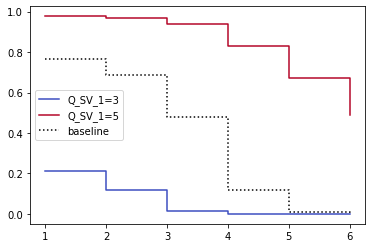

In [22]:
coxph.plot_partial_effects_on_outcome(covariates = 'Q_SV_1', values = [3,5], cmap = 'coolwarm')

##### Qualifiers RC1 (My Cloud)

<AxesSubplot:>

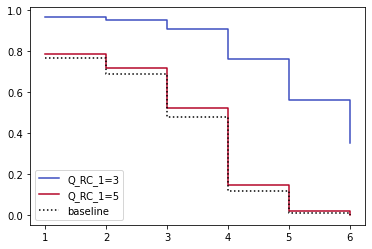

In [23]:
coxph.plot_partial_effects_on_outcome(covariates = 'Q_RC_1', values = [3,5], cmap = 'coolwarm')

##### Qualifiers LN1 (Axeria)

<AxesSubplot:>

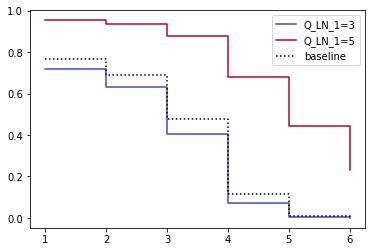

In [24]:
coxph.plot_partial_effects_on_outcome(covariates = 'Q_LN_1', values = [3,5], cmap = 'coolwarm')

##### Qualifiers RC2 (Old Nothing)

<AxesSubplot:>

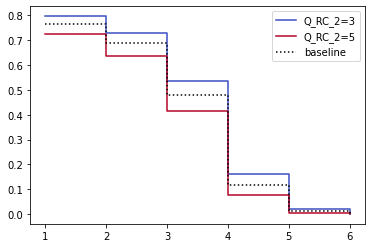

In [25]:
coxph.plot_partial_effects_on_outcome(covariates = 'Q_RC_2', values = [3,5], cmap = 'coolwarm')

##### Qualifiers HB1 (Mei Mode)

<AxesSubplot:>

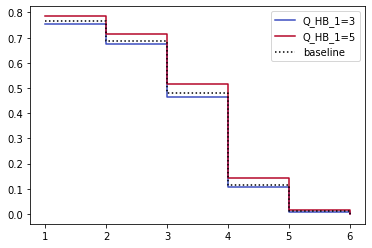

In [26]:
coxph.plot_partial_effects_on_outcome(covariates = 'Q_HB_1', values = [3,5], cmap = 'coolwarm')

#### Cox-Proportional Hazard Model Assumptions Checking

To ensure the model shows the accurate result, we need to check the assumptions of the model

In [27]:
coxph.check_assumptions(data, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


[]

According to the result of assumptions checking, it is okay to use Cox-Proportional Hazard Model.

### Parametric Models for Survival Analysis

Here we are going to use the Parametric Models to analyze the survival chance further. We considered four models
- Weibull
- Exponential
- Log Normal
- Log Logistic

So basically what these models do is trying to fit our survival dataset (time and event) into their survival distributions (namely Right-Tail Cumulative Distribution of each PDF) to find the best distribution that fits our bracket stage elimination process, then we will add Qualifiers Scores parameters in the next step.

However, we use the **Akaike information criterion (AIC)** to select the best model according to the `time` parameter

In [28]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data["time"], event_observed = data["status"])
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 121.87396197682156
The AIC value for ExponentialFitter is 125.80343485020637
The AIC value for LogNormalFitter is 118.26327781832825
The AIC value for LogLogisticFitter is 122.04685002045709


We can see that the **Log Normal Survival Model** has the lowest AIC, so we will use Log-Normal for the further Observation

#### Accelerated Failure Time Model

We can put the parametric model on steroid by using **Accelerated Failure Time Model (AFT)** which will consider the external parameters (example, Qualifiers Scores) into the consideration of our survival model. The interpretation of AFT is similar to Cox-Proportional Hazard Model and these models are more accurate than Cox-Proportional Hazard Model (and we can use them to predict the survival function if I remember correctly).

#### Model Fitting and Summary

In [29]:
from lifelines import LogNormalAFTFitter

In [30]:
lognormal_aft = LogNormalAFTFitter()

In [31]:
lognormal_aft.fit(data, duration_col='time', event_col='status')

<lifelines.LogNormalAFTFitter: fitted with 32 total observations, 1 right-censored observations>

In [32]:
lognormal_aft.print_summary(decimals=3)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.LogNormalAFTFitter: fitted with 32 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 32
number of events observed = 31
           log-likelihood = -38.166
         time fit was run = 2022-08-02 06:20:15 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                         
mu_    Q_HB_1     0.199      1.221      0.425           -0.633            1.032                0.531                2.807
       Q_LN_1     0.306      1.358      0.285           -0.252            0.864                0.777                2.373
       Q_RC_1    -0.197      0.821      0.329           -0.843            0.449                0.431                1.566
       Q_RC_2    -0.063      0.939      0.289           -0.629            0.504                0.533                1.655
       Q_SV_1     0.904      2.470      0.287            0.343            1.466                1.409                4.331
       Intercept -3.200      0.041      0.879           -4.922           -1.478                0.007                0.228
sigma_ Intercept -0.886      0.412      0.128           -1.136           -0.636                0.321                0.530

                   cmp to      z       p   -log2(p)
param  covariate                                   
mu_    Q_HB_1       0.000  0.469   0.639      0.646
       Q_LN_1       0.000  1.075   0.282      1.825
       Q_RC_1       0.000 -0.598   0.550      0.863
       Q_RC_2       0.000 -0.217   0.828      0.273
       Q_SV_1       0.000  3.156   0.002      9.287
       Intercept    0.000 -3.641 <0.0005     11.849
sigma_ Intercept    0.000 -6.939 <0.0005     37.879
---
Concordance = 0.929
AIC = 90.331
log-likelihood ratio test = 37.932 on 5 df
-log2(p) of ll-ratio test = 21.292

From the summary of the **Log-Normal Accelerated Failure Time Model** we can see that 

- **Q_SV_1** or [**Blackorient**](https://osu.ppy.sh/beatmapsets/1349422#mania/2793977) affects the chance of survival by increasing the survival time by approximately **147%** if the **score_logit** is increased by 1.
- **Q_RC_1** or [**My Cloud**](https://osu.ppy.sh/beatmapsets/1349413#mania/2793965) effects the chance of survival by decreasing the survival time by approximately **18%** if the **score_logit** is increased by 1.
- **Q_LN_1** or or [**Axeria**](https://osu.ppy.sh/beatmapsets/1349415#mania/2793968) affects the chance of survival by increasing the survival time by approximately **36%** if the **score_logit** is increased by 1.
- **Q_RC_2** or or [**Old Nothing**](https://osu.ppy.sh/beatmapsets/1349409#mania/2793960) affects the chance of survival by decreasing the survival time by approximately **6%** if the **score_logit** is increased by 1.
- **Q_HB_1** or or [**Mei Mode**](https://osu.ppy.sh/beatmapsets/1349416#mania/2793969) affects the chance of survival by increasing the survival time by approximately **22%** if the **score_logit** is increased by 1.

#### Partial Effects Visualization

This part of the analysis is about visualizing how score of each stage affects the survival rate of each round

We will have 3 graphs to visualize the partial effects
- **[ROUND_CATEGORY_TAG] = 3** : Simulating the situation where the average team score is 952574 (approx 950k) or the total score is approximately 2850000 or `logit(score) = 3`
- **[ROUND_CATEGORY_TAG] = 5** : Simulating the situation where the average team score is 993307 (approx 993k) or the total score is approximately 2979000 or `logit(score) = 5`
- **Baseline** : The baseline Log Normal model plotting of the survival chance

<AxesSubplot:>

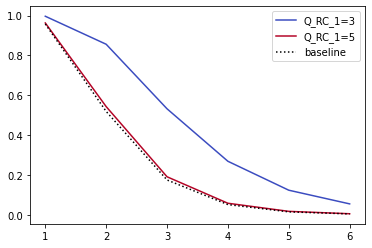

In [33]:
lognormal_aft.plot_partial_effects_on_outcome(covariates = 'Q_RC_1', values = [3,5], cmap = 'coolwarm')

<AxesSubplot:>

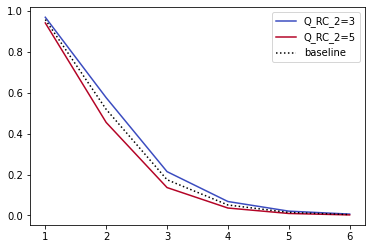

In [34]:
lognormal_aft.plot_partial_effects_on_outcome(covariates = 'Q_RC_2', values = [3,5], cmap = 'coolwarm')

<AxesSubplot:>

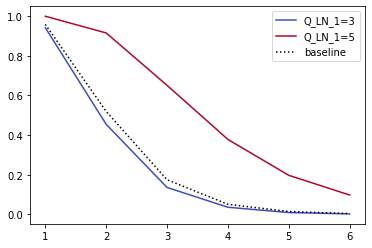

In [35]:
lognormal_aft.plot_partial_effects_on_outcome(covariates = 'Q_LN_1', values = [3,5], cmap = 'coolwarm')

<AxesSubplot:>

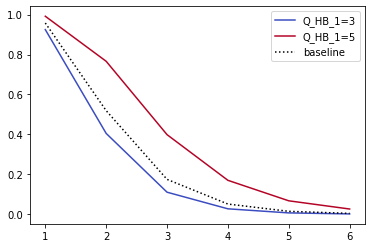

In [36]:
lognormal_aft.plot_partial_effects_on_outcome(covariates = 'Q_HB_1', values = [3,5], cmap = 'coolwarm')

<AxesSubplot:>

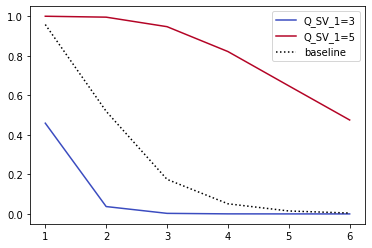

In [37]:
lognormal_aft.plot_partial_effects_on_outcome(covariates = 'Q_SV_1', values = [3,5], cmap = 'coolwarm')

In [38]:
print("Median Survival Time", lognormal_aft.median_survival_time_)
print("Mean Survival Time", lognormal_aft.mean_survival_time_)

Median Survival Time 2.0399630868995247
Mean Survival Time 2.2210289757227786


#### AFT Model Prediction

We use our previous **Log Normal Accelerated Failure Time** model to predict the survival rate of each country.

##### Survival Function Prediction

Here, the model predicts the chance of survival in each round for each country according to Qualifiers Scores

In [39]:
country_survival_prediction = lognormal_aft.predict_survival_function(_4dm3_teams_qualifiers_table)

country_survival_prediction

,Argentina,Australia,Belgium,Brazil,Canada,Switzerland,China,Germany,Dominican Republic,Spain,...,Poland,Romania,Russian Federation,Sweden,Singapore,Thailand,Turkey,"Taiwan, Province of China",United States,Viet Nam
1.0,0.901839,0.859768,0.997863,0.999999,0.480668,1.447423e-01,0.963091,0.968673,0.607002,0.941000,...,0.999681,6.247419e-02,0.746839,0.793518,0.867076,0.997030,0.799754,0.977959,0.999961,2.795505e-01
2.0,0.348771,0.273765,0.880289,0.998623,0.041885,3.071982e-03,0.542604,0.571777,0.079383,0.453223,...,0.958540,6.520523e-04,0.154775,0.194328,0.284994,0.857760,0.200454,0.630272,0.988388,1.175873e-02
3.0,0.085061,0.056524,0.576623,0.977822,0.003340,9.836845e-05,0.190467,0.211198,0.008369,0.135515,...,0.773620,1.344943e-05,0.022786,0.032502,0.060422,0.534719,0.034139,0.257653,0.900878,5.809034e-04
4.0,0.019255,0.011238,0.307021,0.905433,0.000325,4.918126e-06,0.057773,0.066827,0.001001,0.036067,...,0.521234,4.894845e-07,0.003499,0.005498,0.012262,0.270787,0.005855,0.088802,0.722069,3.978916e-05
5.0,0.004521,0.002377,0.147921,0.779962,0.000039,3.491768e-07,0.017222,0.020629,0.000141,0.009659,...,0.312836,2.710802e-08,0.000602,0.001022,0.002636,0.124761,0.001100,0.029429,0.519110,3.615971e-06
6.0,0.001135,0.000547,0.068444,0.629289,0.000006,3.260100e-08,0.005280,0.006514,0.000023,0.002706,...,0.176206,2.063862e-09,0.000117,0.000211,0.000615,0.055512,0.000229,0.009868,0.346727,4.135985e-07


We then want to observe the survival chance of **Philippines** (1st Place) and **United States** (Semifinals) according to Qualifiers Scores

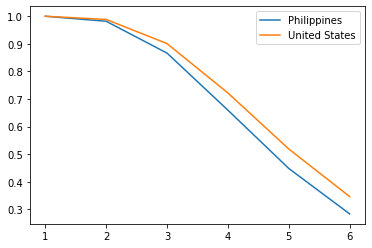

In [40]:
ph_survival_chance = country_survival_prediction['Philippines']
us_survival_chance = country_survival_prediction['United States']

ph_survival_chance.plot()
us_survival_chance.plot()
plt.legend()

According to Qualifiers Scores, **United States** has a slightly higher chance of survival in late game (Semifinals to Grand Finals). But the survival chance at the early game is equivalent to each other.

##### Survival Time Prediction

Here, we use the model to predict the **Survival Time** or **Survival Round** of each country.

In [41]:
country_median_survival_prediction = lognormal_aft.predict_median(_4dm3_teams_qualifiers_table)
country_median_survival_prediction = pd.DataFrame(country_median_survival_prediction, columns=['median_surv'])
country_median_survival_prediction.head()

,median_surv
Argentina,1.703815
Australia,1.560647
Belgium,3.248892
Brazil,6.874649
Canada,0.980206


We use `surv_value_to_round` to convert the `median_surv` to the interpretable data, namely the round that the country is expected to be survived.

In [44]:
rounds = ['GS', 'RO16', 'QF', 'SF', 'F', 'GF']
def surv_value_to_round(median_surv):
    return rounds[min(round(median_surv)-1, 5)]

We then convert the data from `median_surv` to `surv_round`

In [45]:
country_median_survival_prediction['surv_round'] = country_median_survival_prediction['median_surv'].apply(surv_value_to_round)
country_median_survival_prediction.sort_values('median_surv', ascending=False).head(10)

,median_surv,surv_round
Brazil,6.874649,GF
Netherlands,6.378391,GF
United States,5.099797,F
Philippines,4.740467,F
France,4.679794,F
Poland,4.088814,SF
Malaysia,3.437959,QF
Belgium,3.248892,QF
Thailand,3.109768,QF
"Korea, Republic of",2.774743,QF


## References

Survival Analysis models and Code : https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d